/var/folders/yj/nhkf3nv505d5kh0dsk42f3ym0000gn/T/ipykernel_44813/2381726645.py:30: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  customer['sell_price'].interpolate(method='linear', inplace=True)


adf:  -2.4834361941144074
p-value:  0.11955666818118582
Critical values:  {'1%': -3.434002362895342, '5%': -2.863153315036348, '10%': -2.5676288771043367}
есть единичные корни, ряд не стационарен


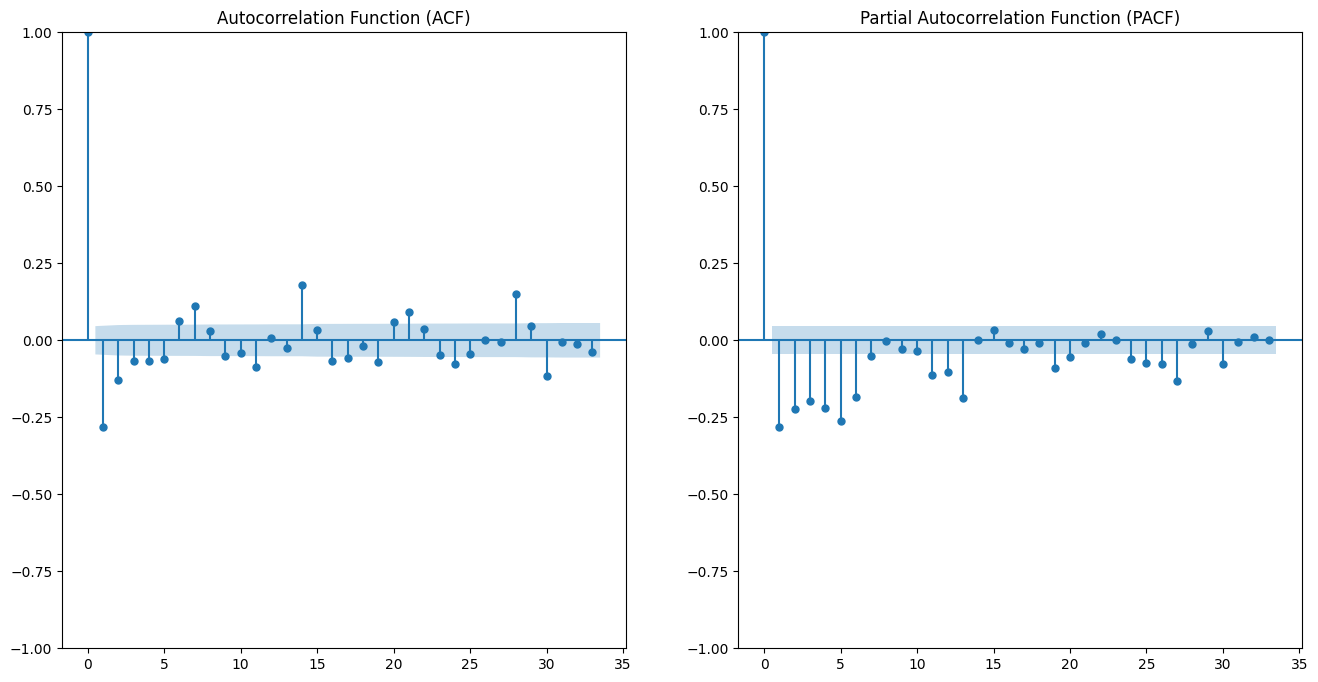

/Users/muzafarov/anaconda3/envs/timeseries/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/muzafarov/anaconda3/envs/timeseries/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/muzafarov/anaconda3/envs/timeseries/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/muzafarov/anaconda3/envs/timeseries/lib/python3.9/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Mean Squared Error: 64.43270833731124
Mean Absolute Error: 6.629713675589396
MAPE: inf%


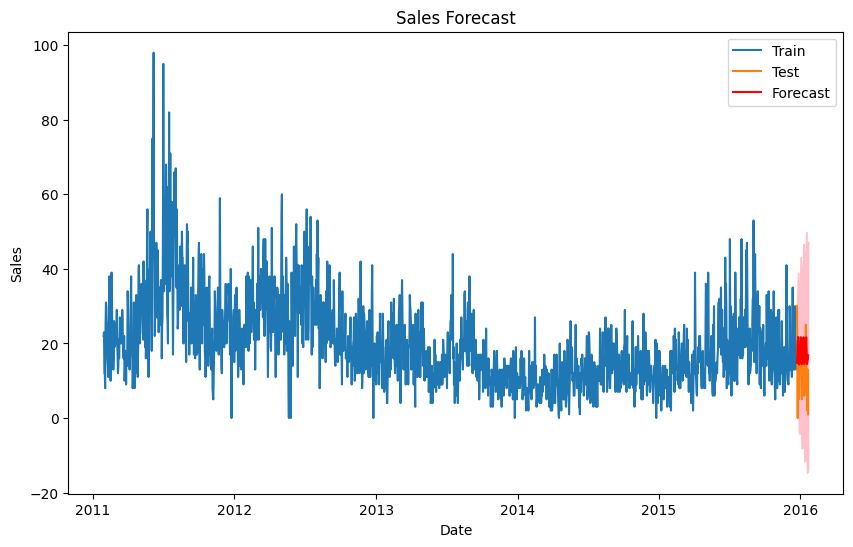

In [66]:
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

# Загрузка данных
sales_data = pd.read_csv('shop_sales.csv')
calendar_data = pd.read_csv('shop_sales_dates.csv')
prices_data = pd.read_csv('shop_sales_prices.csv')

# Подготовка данных
sales_data['week_id'] = (sales_data['date_id'] - 1) // 7 + 11101
merged_data = pd.merge(sales_data, prices_data, how='left', 
                       left_on=['store_id', 'item_id', 'week_id'], 
                       right_on=['store_id', 'item_id', 'wm_yr_wk'])
merged_data.drop(columns=['wm_yr_wk'], inplace=True)

# Выбор данных для конкретного магазина и товара
store_id = 'STORE_1'
item_id = 'STORE_1_252'
customer = merged_data[(merged_data['store_id'] == store_id) & (merged_data['item_id'] == item_id)]
customer = pd.merge(customer, calendar_data, on='date_id', how='inner')
customer = customer.rename(columns={'date': 'ds', 'cnt': 'y'})
customer['ds'] = pd.to_datetime(customer['ds'])
customer.set_index('ds', inplace=True)

# Заполнение пропущенных значений в sell_price
customer['sell_price'].interpolate(method='linear', inplace=True)

# Проверка стационарности ряда
test = sm.tsa.adfuller(customer['y'])
print('adf: ', test[0])
print('p-value: ', test[1])
print('Critical values: ', test[4])

if test[0] > test[4]['5%']: 
    print('есть единичные корни, ряд не стационарен')
    customer['y_diff'] = customer['y'].diff().dropna()
    data_to_plot = customer['y_diff']
else:
    print('единичных корней нет, ряд стационарен')
    data_to_plot = customer['y']

# Построение графиков ACF и PACF
fig, axes = plt.subplots(1, 2, figsize=(16, 8))

plot_acf(data_to_plot.dropna(), ax=axes[0])
axes[0].set_title('Autocorrelation Function (ACF)')

plot_pacf(data_to_plot.dropna(), ax=axes[1])
axes[1].set_title('Partial Autocorrelation Function (PACF)')

plt.show()

# Разделение данных на тренировочные и тестовые
train_data = customer.iloc[:-30]
test_data = customer.iloc[-30:]

# Определение порядка для модели ARIMA
order = (6, 1, 7)  # Параметры модели ARIMA (p, d, q)
seasonal_order = (0, 1, 0, 7)  # Сезонные параметры модели (P, D, Q, S)

# Обучение модели
model = sm.tsa.SARIMAX(train_data['y'], exog=train_data[['sell_price']], order=order, seasonal_order=seasonal_order)
model_fit = model.fit(disp=False)

# Прогнозирование
forecast = model_fit.get_forecast(steps=len(test_data), exog=test_data[['sell_price']])
forecast_ci = forecast.conf_int()

# Вывод метрик и построение графиков
predicted_values = forecast.predicted_mean
actual_values = test_data['y']

mse = mean_squared_error(actual_values, predicted_values)
mae = mean_absolute_error(actual_values, predicted_values)
mape = np.mean(np.abs((actual_values - predicted_values) / actual_values)) * 100

print(f'Mean Squared Error: {mse}')
print(f'Mean Absolute Error: {mae}')
print(f'MAPE: {mape}%')

# График прогноза и фактических данных
plt.figure(figsize=(10, 6))
plt.plot(train_data.index, train_data['y'], label='Train')
plt.plot(test_data.index, test_data['y'], label='Test')
plt.plot(test_data.index, forecast.predicted_mean, label='Forecast', color='r')
plt.fill_between(test_data.index, forecast_ci.iloc[:, 0], forecast_ci.iloc[:, 1], color='pink')
plt.title('Sales Forecast')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.show()
